# 1. Install Dependencies and Setup

In [5]:
!pip install tensorflow opencv-python matplotlib

In [6]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [7]:
import tensorflow as tf
import os

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

In [11]:
data_dir = 'data'

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

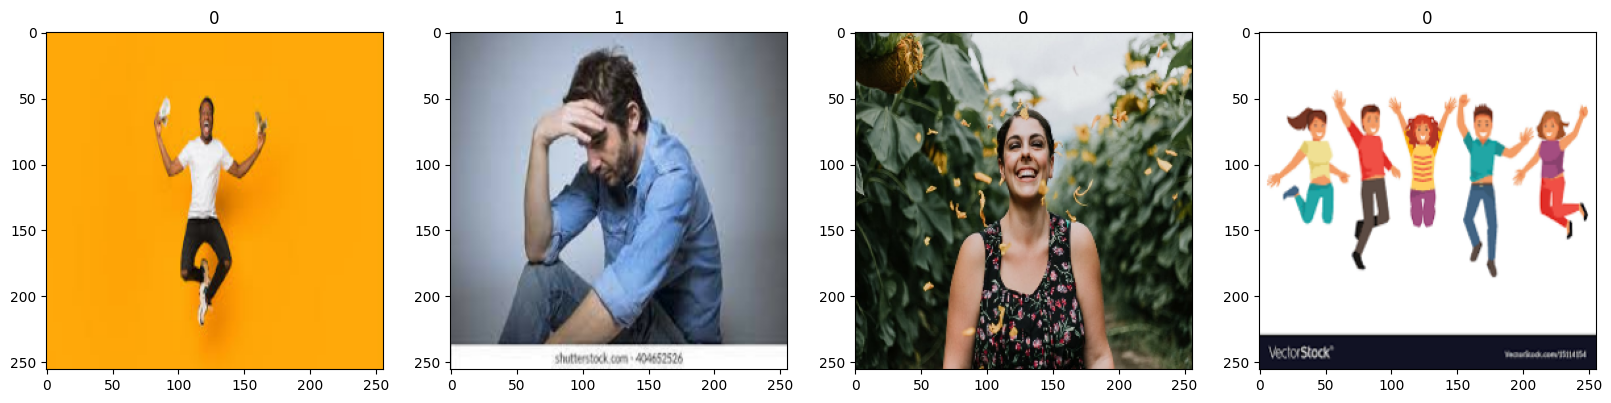

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[5.3725493e-01, 6.5490198e-01, 7.5686276e-01],
          [5.3725493e-01, 6.5490198e-01, 7.5686276e-01],
          [5.3725493e-01, 6.5490198e-01, 7.5686276e-01],
          ...,
          [4.4804305e-01, 2.7026272e-01, 1.5425092e-01],
          [4.9019608e-01, 2.9607844e-01, 1.6274510e-01],
          [5.3464305e-01, 3.2679993e-01, 1.6601562e-01]],
 
         [[5.3920805e-01, 6.5685511e-01, 7.5881588e-01],
          [5.3920805e-01, 6.5685511e-01, 7.5881588e-01],
          [5.3920805e-01, 6.5685511e-01, 7.5881588e-01],
          ...,
          [4.2843521e-01, 2.6176855e-01, 1.5392540e-01],
          [4.8824295e-01, 2.9412532e-01, 1.6079198e-01],
          [5.2745098e-01, 3.1960785e-01, 1.5882353e-01]],
 
         [[5.4117650e-01, 6.5882355e-01, 7.6078433e-01],
          [5.4117650e-01, 6.5882355e-01, 7.6078433e-01],
          [5.4117650e-01, 6.5882355e-01, 7.6078433e-01],
          ...,
          [4.0066636e-01, 2.4901961e-01, 1.4705883e-01],
          [4.7517616e-01, 2.8105852e-

# 5. Split Data

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

7

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 12s 700ms/step - loss: 1.8582 - accuracy: 0.5491 - val_loss: 1.0831 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 6s 605ms/step - loss: 0.7583 - accuracy: 0.5223 - val_loss: 0.6631 - val_accuracy: 0.6562
Epoch 3/20
7/7 [==============================] - 7s 810ms/step - loss: 0.6689 - accuracy: 0.5893 - val_loss: 0.6208 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - 6s 612ms/step - loss: 0.6006 - accuracy: 0.7679 - val_loss: 0.4897 - val_accuracy: 0.7969
Epoch 5/20
7/7 [==============================] - 7s 670ms/step - loss: 0.4548 - accuracy: 0.7857 - val_loss: 0.3612 - val_accuracy: 0.7969
Epoch 6/20
7/7 [==============================] - 6s 599ms/step - loss: 0.3433 - accuracy: 0.8616 - val_loss: 0.3076 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 7s 797ms/step - loss: 0.2670 - accuracy: 0.8973 - val_loss: 0.2814 - val_accuracy: 0.8594
Epoch 8/20
7/7 [===

# 8. Plot Performance

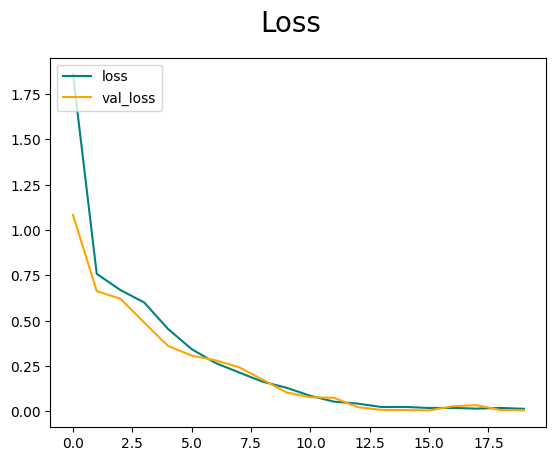

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

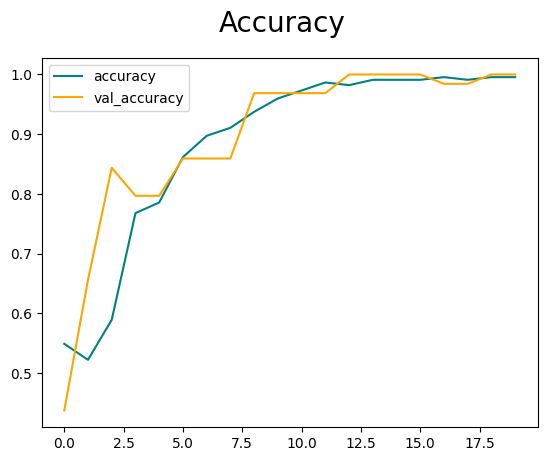

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 433ms/step


In [40]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


# 10. Test

In [41]:
import cv2

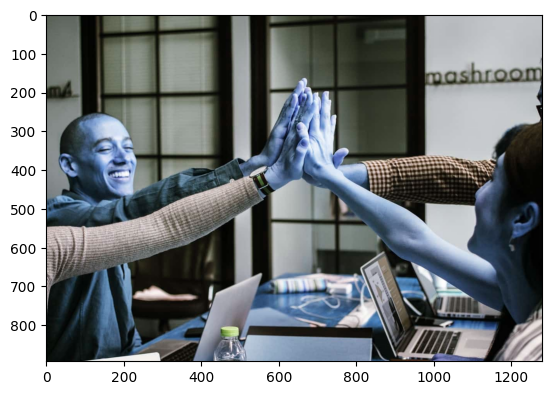

In [46]:
img = cv2.imread('/content/data/happy/7-Habits-of-Happy-People-image.jpeg')
plt.imshow(img)
plt.show()

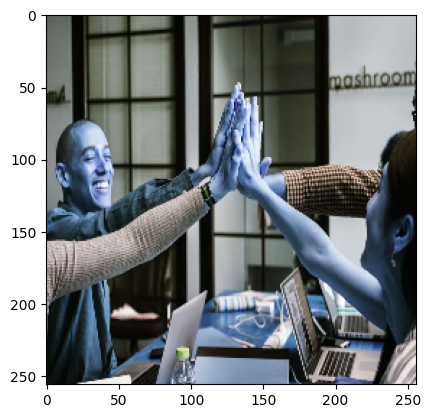

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 202ms/step


In [49]:
yhat

array([[2.9773696e-06]], dtype=float32)

In [50]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [54]:
model.save(os.path.join('models','imageclassifier.h5'))

In [55]:
new_model = load_model('models/imageclassifier.h5')

In [56]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 72ms/step


array([[2.9773696e-06]], dtype=float32)